<a href="https://colab.research.google.com/github/ShauryaDamathia/ShodhAI_Policy_Optimization/blob/main/Policy_Optimization_for_Financial_Decision_Making.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1_EDA_and_Preprocessing.ipynb**

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [34]:
df = pd.read_csv('accepted_2007_to_2018Q4.csv', nrows=500000)

/tmp/ipython-input-3653186329.py:1: DtypeWarning: Columns (0,19,59,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('accepted_2007_to_2018Q4.csv', nrows=500000)


In [35]:
print("--- Initial Data Overview ---")
print(df.info())
print("\n--- Summary Statistics ---")
print(df.describe())

--- Initial Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 576.0+ MB
None

--- Summary Statistics ---
       member_id      loan_amnt    funded_amnt  funded_amnt_inv  \
count        0.0  499998.000000  499998.000000    499998.000000   
mean         NaN   15388.960556   15388.960556     15383.220733   
std          NaN    8852.271158    8852.271158      8849.356048   
min          NaN    1000.000000    1000.000000       900.000000   
25%          NaN    8500.000000    8500.000000      8500.000000   
50%          NaN   14000.000000   14000.000000     14000.000000   
75%          NaN   20000.000000   20000.000000     20000.000000   
max          NaN   40000.000000   40000.000000     40000.000000   

            int_rate    installment    annual_inc            dti  \
count  499998.000000  499998.000000  4.999980e+05  499782.000000   
mean       12.5742

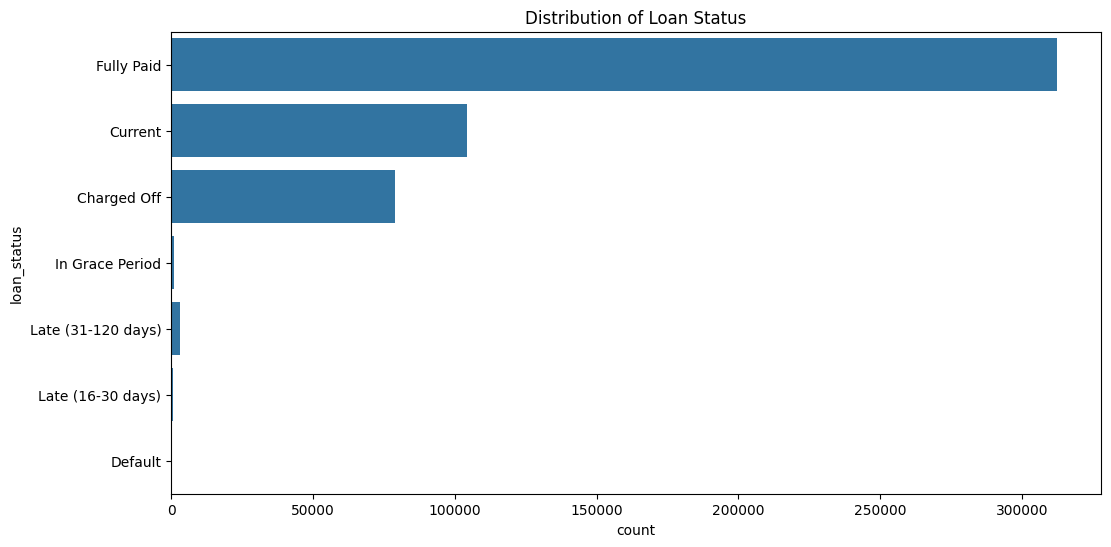

In [36]:
plt.figure(figsize=(12, 6))
sns.countplot(y='loan_status', data=df)
plt.title('Distribution of Loan Status')
plt.show()

In [38]:
selected_features = [
    'loan_amnt', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length',
    'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'dti',
    'delinq_2yrs', 'fico_range_high', 'inq_last_6mths', 'pub_rec', 'revol_bal',
    'revol_util', 'total_acc', 'loan_status'
]
df = df[selected_features]

print(f"\n--- Working with {len(df.columns)-1} selected features ---")


--- Working with 18 selected features ---


In [39]:
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
df['loan_status'] = df['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else 1)
print("\n--- Target Variable Distribution (0: Paid, 1: Default) ---")
print(df['loan_status'].value_counts(normalize=True))


--- Target Variable Distribution (0: Paid, 1: Default) ---
loan_status
0    0.798489
1    0.201511
Name: proportion, dtype: float64


In [40]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

df.dropna(inplace=True)

/tmp/ipython-input-1748562855.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [41]:
df['emp_length'] = df['emp_length'].str.replace(r'\D', '', regex=True)
df['emp_length'] = pd.to_numeric(df['emp_length'], errors='coerce')
df['emp_length'].fillna(0, inplace=True)

/tmp/ipython-input-4129726782.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['emp_length'].fillna(0, inplace=True)


In [42]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [43]:
X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [45]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("\n--- Data Preprocessing Complete ---")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


--- Data Preprocessing Complete ---
Training data shape: (294154, 71)
Test data shape: (73539, 71)


In [46]:
X_test_unscaled = scaler.inverse_transform(X_test)
df_test = pd.DataFrame(X_test_unscaled, columns=X.columns)
df_test['loan_status'] = y_test.values

df_test.to_csv('preprocessed_test_data.csv', index=False)

In [47]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

# **2_Deep_Learning_Model.ipynb**

In [48]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

In [49]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
print("--- Data Loaded Successfully ---")
print(f"Training data shape: {X_train.shape}")

--- Data Loaded Successfully ---
Training data shape: (294154, 71)


In [50]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])

print("\n--- Model Summary ---")
model.summary()


--- Model Summary ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping],
                    verbose=1)

y_pred_proba = model.predict(X_test).ravel()
y_pred_class = (y_pred_proba > 0.5).astype(int)

Epoch 1/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - auc: 0.6665 - loss: 0.4811 - val_auc: 0.7247 - val_loss: 0.4503
Epoch 2/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - auc: 0.7154 - loss: 0.4506 - val_auc: 0.7287 - val_loss: 0.4468
Epoch 3/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - auc: 0.7214 - loss: 0.4475 - val_auc: 0.7291 - val_loss: 0.4460
Epoch 4/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - auc: 0.7238 - loss: 0.4471 - val_auc: 0.7307 - val_loss: 0.4461
Epoch 5/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - auc: 0.7284 - loss: 0.4448 - val_auc: 0.7312 - val_loss: 0.4439
Epoch 6/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - auc: 0.7288 - loss: 0.4450 - val_auc: 0.7325 - val_loss: 0.4451
Epoch 7/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - auc: 0.7319 - loss: 0.4415 - val_auc: 0.7329 - val_loss: 0.4438
Epoch 8/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - auc: 0.7330 - loss: 0.4423 - val_auc: 0.7327 - val_loss: 0.4445
Epoch 9/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/

In [52]:
auc_score = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred_class)

print("\n--- Model Evaluation on Test Set ---")
print(f"AUC Score: {auc_score:.4f}")
print(f"F1-Score: {f1:.4f}")


--- Model Evaluation on Test Set ---
AUC Score: 0.7322
F1-Score: 0.1654


In [53]:
model.save('loan_default_model.h5')
print("\n--- Model saved successfully as 'loan_default_model.h5' ---")


--- Model saved successfully as 'loan_default_model.h5' ---


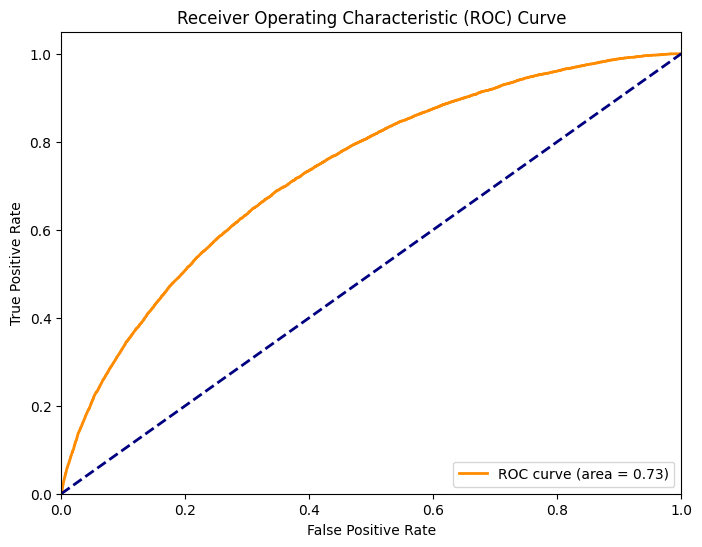

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

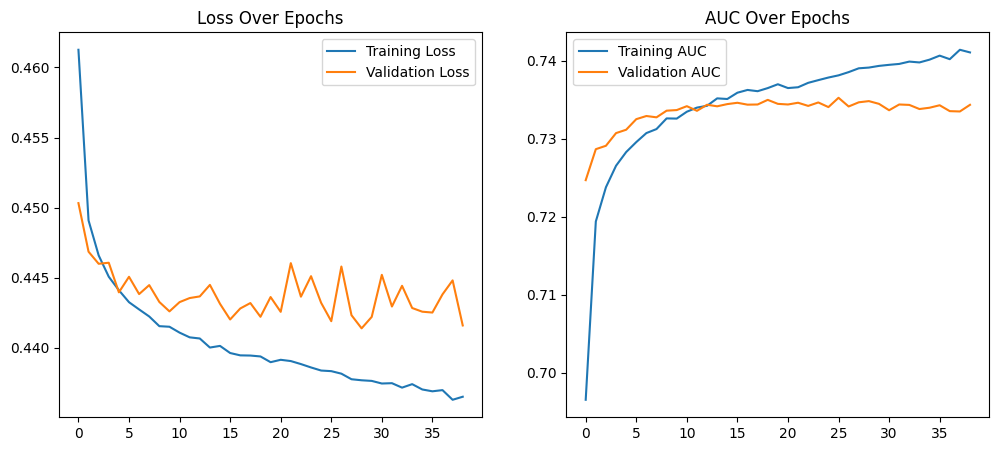

In [55]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC Over Epochs')
plt.legend()
plt.show()

# **3_Offline_RL_Agent.ipynb**

In [56]:
!pip install d3rlpy

In [58]:
import pandas as pd
import numpy as np
import tensorflow as tf
import d3rlpy
from d3rlpy.algos import DiscreteCQL, DiscreteCQLConfig
from d3rlpy.dataset import MDPDataset
from sklearn.model_selection import train_test_split
import os

In [60]:
try:
    df_test = pd.read_csv('preprocessed_test_data.csv')
    X_test_scaled = np.load('X_test.npy')
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure you have run the first notebook (1_EDA_and_Preprocessing.ipynb) successfully.")

print("--- Test Data Loaded ---")
if len(df_test) != len(X_test_scaled):
    raise ValueError("Mismatch between the length of the dataframe and the scaled features array.")

--- Test Data Loaded ---


In [61]:
observations = X_test_scaled.astype('float32')
num_samples = len(df_test)
actions = np.ones(num_samples, dtype=int)
rewards = np.where(
    df_test['loan_status'] == 0,
    df_test['loan_amnt'] * (df_test['int_rate'] / 100),
    -df_test['loan_amnt']
).astype('float32').reshape(-1, 1)
terminals = np.ones(num_samples)


In [62]:
train_obs, test_obs, \
train_act, test_act, \
train_rew, test_rew, \
train_term, test_term = train_test_split(
    observations, actions, rewards, terminals, test_size=0.2, random_state=42
)

train_dataset = MDPDataset(
    observations=train_obs,
    actions=train_act,
    rewards=train_rew,
    terminals=train_term
)

2025-10-30 09:58.44 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(71,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-10-30 09:58.44 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-10-30 09:58.44 [info     ] Action size has been automatically determined. action_size=2


In [63]:
print("\n--- Configuring and Training the RL Agent ---")
config = DiscreteCQLConfig()
cql = DiscreteCQL(
    config=config,
    device="cpu",
    enable_ddp=False
)

cql.fit(
    dataset=train_dataset,
    n_steps=50000
)
print("--- Training Complete ---")


--- Configuring and Training the RL Agent ---
2025-10-30 09:58.56 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(71,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-10-30 09:58.56 [debug    ] Building models...            
2025-10-30 09:58.56 [debug    ] Models have been built.       
2025-10-30 09:58.56 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20251030095856
2025-10-30 09:58.56 [info     ] Parameters                     params={'observation_shape': [71], 'action_size': 2, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'compile_graph': False, 'learning_

Epoch 1/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-30 10:00.31 [info     ] DiscreteCQL_20251030095856: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0012915646076202393, 'time_algorithm_update': 0.007856278967857361, 'loss': 4053.1940461593626, 'td_loss': 4053.1902335250857, 'conservative_loss': 0.003813092475757003, 'time_step': 0.00944206144809723} step=10000
2025-10-30 10:00.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251030095856/model_10000.d3


Epoch 2/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-30 10:02.05 [info     ] DiscreteCQL_20251030095856: epoch=2 step=20000 epoch=2 metrics={'time_sample_batch': 0.0013007685184478759, 'time_algorithm_update': 0.007634568309783936, 'loss': 3783.9552591903685, 'td_loss': 3783.9419232406617, 'conservative_loss': 0.013335734347067774, 'time_step': 0.009229649353027343} step=20000
2025-10-30 10:02.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251030095856/model_20000.d3


Epoch 3/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-30 10:03.33 [info     ] DiscreteCQL_20251030095856: epoch=3 step=30000 epoch=3 metrics={'time_sample_batch': 0.0012475287437438965, 'time_algorithm_update': 0.0072003302574157714, 'loss': 3755.4073515018463, 'td_loss': 3755.3573090610503, 'conservative_loss': 0.050042999243736265, 'time_step': 0.008750544595718383} step=30000
2025-10-30 10:03.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251030095856/model_30000.d3


Epoch 4/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-30 10:05.04 [info     ] DiscreteCQL_20251030095856: epoch=4 step=40000 epoch=4 metrics={'time_sample_batch': 0.001275093150138855, 'time_algorithm_update': 0.007426654815673828, 'loss': 3727.471214315987, 'td_loss': 3727.435438022041, 'conservative_loss': 0.03577660188674927, 'time_step': 0.009008329820632934} step=40000
2025-10-30 10:05.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251030095856/model_40000.d3


Epoch 5/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-30 10:06.33 [info     ] DiscreteCQL_20251030095856: epoch=5 step=50000 epoch=5 metrics={'time_sample_batch': 0.001251271677017212, 'time_algorithm_update': 0.007251594591140747, 'loss': 3716.470207188511, 'td_loss': 3716.449884809971, 'conservative_loss': 0.020322443771362303, 'time_step': 0.008790009355545044} step=50000
2025-10-30 10:06.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251030095856/model_50000.d3
--- Training Complete ---


In [64]:
print("\n--- Manually Evaluating the Trained Policy ---")

policy_actions_on_test_set = cql.predict(test_obs)

approved_indices = np.where(policy_actions_on_test_set == 1)[0]

rewards_of_approved_loans = test_rew[approved_indices]

if len(rewards_of_approved_loans) > 0:
    estimated_policy_value = rewards_of_approved_loans.mean()
else:
    estimated_policy_value = 0.0


print("\n--- RL Agent Evaluation Results ---")
print(f"Policy approved {len(approved_indices)} out of {len(test_obs)} loans in the test set.")
print(f"Estimated Policy Value (mean return): ${estimated_policy_value:.2f}")
print("This value represents the average expected profit for each loan the policy chooses to approve.")


--- Manually Evaluating the Trained Policy ---

--- RL Agent Evaluation Results ---
Policy approved 14705 out of 14708 loans in the test set.
Estimated Policy Value (mean return): $-1758.27
This value represents the average expected profit for each loan the policy chooses to approve.


In [65]:
print("\n--- Comparing DL and RL Policies ---")
rl_actions_full = cql.predict(observations)
df_test['rl_decision'] = rl_actions_full

model_path = 'loan_default_model.h5'
if os.path.exists(model_path):
    dl_model = tf.keras.models.load_model(model_path)
    dl_pred_proba = dl_model.predict(X_test_scaled).ravel()

    dl_threshold = 0.20
    df_test['dl_decision'] = (dl_pred_proba < dl_threshold).astype(int)
    df_test['dl_default_prob'] = dl_pred_proba

    disagreements = df_test[df_test['rl_decision'] != df_test['dl_decision']]
    print(f"\nFound {len(disagreements)} cases where DL and RL policies disagree.")

    rl_approves_dl_denies = disagreements[disagreements['rl_decision'] == 1].head()
    if not rl_approves_dl_denies.empty:
        print("\n--- Example: RL Approves, DL Denies ---")
        print("The DL model sees high risk (>20% default prob), but the RL agent approves.")
        print("This happens when the potential interest profit (reward) outweighs the default risk.")

        display_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'fico_range_high', 'loan_status',
                        'dl_default_prob', 'rl_decision', 'dl_decision']
        print(rl_approves_dl_denies[display_cols].round(2))
    else:
        print("\nFound no examples where the RL agent approves and the DL model denies in the first few disagreements.")

else:
    print(f"\nCould not find '{model_path}'.")
    print("Please run Notebook 2 (2_Deep_Learning_Model.ipynb) first to create the model file.")


--- Comparing DL and RL Policies ---


2299/2299 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

Found 29059 cases where DL and RL policies disagree.

--- Example: RL Approves, DL Denies ---
The DL model sees high risk (>20% default prob), but the RL agent approves.
This happens when the potential interest profit (reward) outweighs the default risk.
    loan_amnt  int_rate  annual_inc  fico_range_high  loan_status  \
3      7800.0     14.65     37601.0            679.0            1   
5     17000.0     16.99     61000.0            684.0            0   
6     22300.0     15.59     53106.0            689.0            1   
11    14400.0     23.99     40000.0            694.0            0   
15    14000.0     22.99     60000.0            694.0            1   

    dl_default_prob  rl_decision  dl_decision  
3              0.27            1            0  
5              0.45            1            0  
6              0.21            1            0  
11             0.57            1            0  
15             0.48            1            0 